# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

### Your task

In the lab work, you must fill in the code in the places marked FILL IN CODE, or answer the written questions directly on the notebook.

In [18]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = False


def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return



(600, 800)

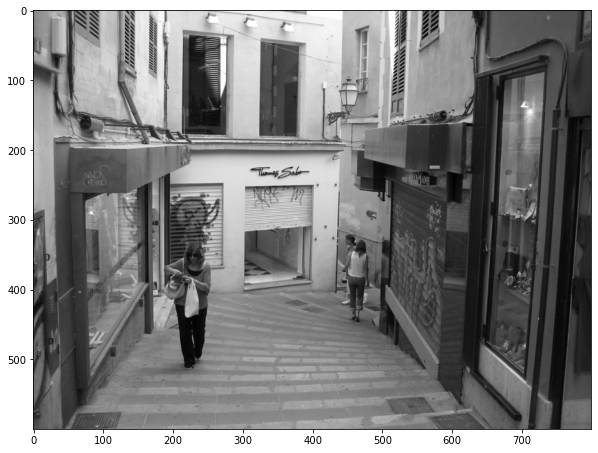

In [19]:
file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper, 0 or 1) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixel values to the range $(0,1)$ (np.clip).

In [20]:
def add_gaussian_noise(img_in,sigma_noise = 0.01):
    noise = np.random.normal(size=img_in.shape)
    img_out = img_in + sigma_noise*noise
    return np.clip(img_out,0,1)

# we define the impulse probability p as the probability of a pixel not being affected
def add_impulse_noise(img_in,p=0.9):
    pixel_choice = np.random.uniform(size=img_in.shape)
    noise = np.random.binomial(n=1,p=0.5,size=img_in.shape)
    img_out = np.multiply(img_in,pixel_choice<=p) + np.multiply(noise,pixel_choice>p)
    return np.clip(img_out,0,1)

def add_missing_pixels_noise(img_in,p=0.9):
    img_out = np.multiply(img_in,np.random.binomial(1,p,img_in.shape))
    return np.clip(img_out,0,1)

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$, the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

In [21]:
sigma_noise = 0.05
img_gray_gaussian = add_gaussian_noise(img_gray, sigma_noise)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')

img_gray_impulse = add_impulse_noise(img_gray, 0.9)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')

img_gray_missing = add_missing_pixels_noise(img_gray, 0.9)
write_image(img_gray_missing,file_name+'_missing_pixels.png')

__Question__ For each type of noise, propose a restoration filter (see course slides).

__Answer__ 

- The most common type of noise, Gaussian noise, is often removed
using a smoothing filter, so I will implement a smoothing Gaussian filter.

- For impulse noise, few pixels are likely to be damaged, and wehen they are damaged they are equally choosen among 0 or 1. Then the median filter is
a good option, since it will not take reaaly into account the few pixels that have been damage to 0 or 1.

- For missing Pixels I could make the median filter as said in the course yet I want to try the maximum filter since it put pixels to zeros, the original pixel has more chance to be like the maximum pixel aroud it than to zero.

Implement these restoration filters in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__IMPORTANT NOTE__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented (do not re-implement the filters)

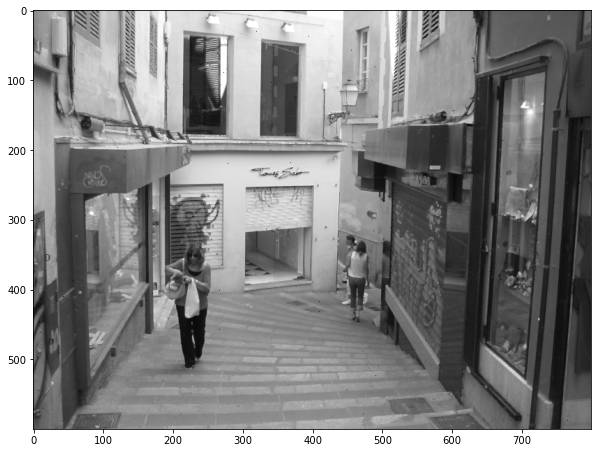

In [22]:
from scipy import ndimage
# CREATE THE FUNCTIONS TO CARRY OUT THE RESTORATION FILTERS AND WRITE THE RESULTS

#Gaussian filter :
def gaussian_filter(img_in,sigma = 1):
    img_out = ndimage.gaussian_filter(img_in, sigma)
    return img_out
#display_image(gaussian_filter(img_gray_gaussian))

#Median Filter : 
def median_filter(img_in, filter_size = (3,3)):
    img_out = ndimage.median_filter(img_in,size = filter_size)
    return img_out
#display_image(median_filter(img_gray_impulse))

#Maximum filter : 
def maximum_filter(img_in, filter_size = (2,2)):
    img_out = ndimage.maximum_filter(img_gray_missing,size=filter_size)
    return img_out

display_image(maximum_filter(img_gray_missing))


__Question__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__

The trade off is between removing noise and keeping the quality of the image. For instance in the median filter if our filter is not large enough we will replace correctly the noise, shile if it is to big, we will get uniform area that represent the median of the image on these area and the picture will not be clear.

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only (first filter)__. 

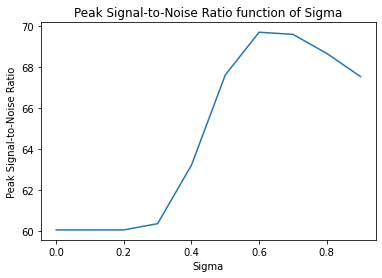

In [23]:
def PSNR(img,img_ref):
    mse = np.mean((img-img_ref)**2)
    psnr = -10*np.log(mse)
    return psnr

res = []
sigma = np.arange(0,1,0.1)
for s in sigma:
    img_restored_gaussian = gaussian_filter(img_gray_gaussian, sigma = s)
    res.append(PSNR(img_restored_gaussian, img_gray))

plt.plot(sigma, res)
plt.title('Peak Signal-to-Noise Ratio function of Sigma')
plt.xlabel('Sigma')
plt.ylabel('Peak Signal-to-Noise Ratio')
plt.show()

## FUTHER RESTORATION TECHNIQUES (THIS IS NOT OBLIGATORY)

## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


(600, 600)

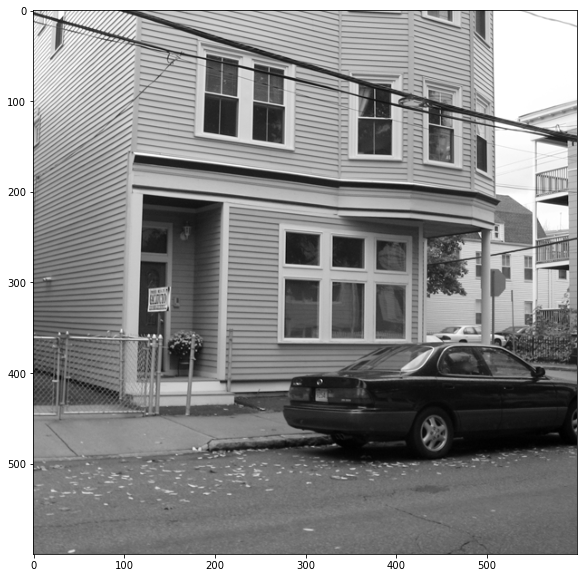

In [24]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)
img_gray.shape

Now, let us consider the following fiter, defined in the Fourier domain :

(600, 600)


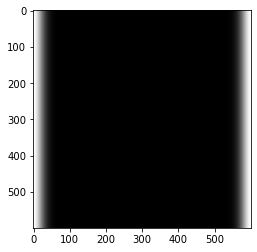

In [25]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

Using the convolution theorem and the inverse Fourier transform, carry out the convolution of the input image with $f$ (in the Fourier domain, so using $\hat{f}$) and write the result ``img_convolved`` to an output file

__Question__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ?
 How can this happen in real life ? 

In [26]:
def filter_image(img,f_hat):
    fq_img = np.fft.fft2(img)
    filtering = np.multiply(f_hat,fq_img) # we apply the filter and the img
    img_out = np.real(np.fft.ifft2(filtering))
    return(img_out)

img_convolved = filter_image(img_gray,f_hat)

img_convolved -= img_convolved.min()
img_convolved /= img_convolved.max()

write_image(img_convolved,file_name+'_convolution.png')
img_convolved.max()

1.0

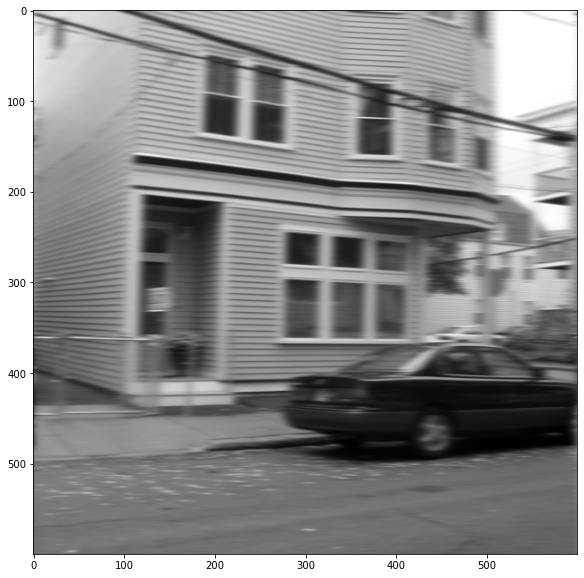

In [27]:
display_image(img_convolved)

__Answer__ 

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue.


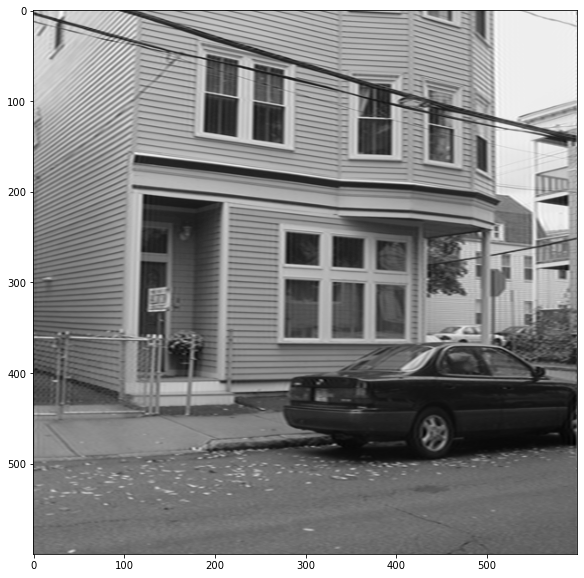

In [28]:
def deconvolve_fourier(img,f_hat):
    eps = 1e-10
    f_hat_bis = f_hat + eps
    img_out = np.fft.ifft2(np.fft.fft2(img)/f_hat_bis)
    return img_out
    

img_out = np.real(deconvolve_fourier(img_convolved,f_hat))
img_out -= img_out.min()
img_out /= img_out.max()


write_image(img_out,file_name+'_deconvolved.png')
display_image(img_out)